In [1]:
#imports
import os
import pandas as pd
from glob import glob
import tensorflow as tf
from tensorflow.keras import losses, optimizers, layers, Sequential
import matplotlib.pyplot as plt

In [2]:
#get image data
os.makedirs('body_score_dataset', exist_ok=True)
!git clone -b body_scores_prediction_dataset https://github.com/MVet-Platform/M-Vet_Hackathon24.git ./body_score_dataset 

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Cloning into './body_score_dataset'...
remote: Enumerating objects: 15246, done.
remote: Counting objects: 100% (3683/3683), done.
remote: Compressing objects: 100% (3664/3664), done.
remote: Total 15246 (delta 20), reused 3677 (delta 17), pack-reused 11563 (from 1)
Receiving objects: 100% (15246/15246), 1.30 GiB | 61.68 MiB/s, done.
Resolving deltas: 100% (61/61), done.
Updating files: 100% (10878/10878), done.


In [3]:
#load label data
df_train_data = pd.read_csv('/kaggle/working/body_score_dataset/train_data.csv')
df_train_data.head()

,filename,bodyScore
0,6c11338b-ce1a-4e23-b505-8d6afaf110f33796968321...,4.0
1,53c3ffb8-ccef-41bf-ae83-bc1954c436417186970590...,3.0
2,c13a8227-7747-4eac-9906-b9dee9b6e14e1858597213...,4.0
3,90bb5ad3-c9bd-4cb7-a950-62f6effad3528612499606...,4.0
4,224ef780-210b-4b9e-a4d9-1ecbff118a246705373022...,3.0


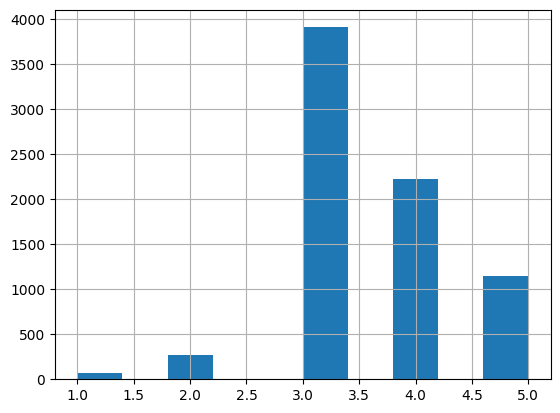

In [4]:
df_train_data['bodyScore'].hist()
plt.show()

In [5]:
#get file path for image files
df_train_data['filepath'] = df_train_data.apply(lambda row: glob(f'body_score_dataset/**/{row.filename}')[0], axis=1)

In [6]:
df_train_data.head()

,filename,bodyScore,filepath
0,6c11338b-ce1a-4e23-b505-8d6afaf110f33796968321...,4.0,body_score_dataset/0003/6c11338b-ce1a-4e23-b50...
1,53c3ffb8-ccef-41bf-ae83-bc1954c436417186970590...,3.0,body_score_dataset/0002/53c3ffb8-ccef-41bf-ae8...
2,c13a8227-7747-4eac-9906-b9dee9b6e14e1858597213...,4.0,body_score_dataset/0005/c13a8227-7747-4eac-990...
3,90bb5ad3-c9bd-4cb7-a950-62f6effad3528612499606...,4.0,body_score_dataset/0004/90bb5ad3-c9bd-4cb7-a95...
4,224ef780-210b-4b9e-a4d9-1ecbff118a246705373022...,3.0,body_score_dataset/0001/224ef780-210b-4b9e-a4d...


In [7]:
#create array of body scores and file paths
body_scores = df_train_data.bodyScore.values
file_paths = df_train_data.filepath.values

In [8]:
#load image and body_score
#apply preprocessing to image
#return image and body_score
def load_and_preprocess_image(file_path, body_score=None):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224]) 
    image = tf.cast(image, tf.float32) / 255.0 
    if body_score is not None:
        return image, body_score
    else:
        return image

In [9]:
# Create a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((file_paths, body_scores))
dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

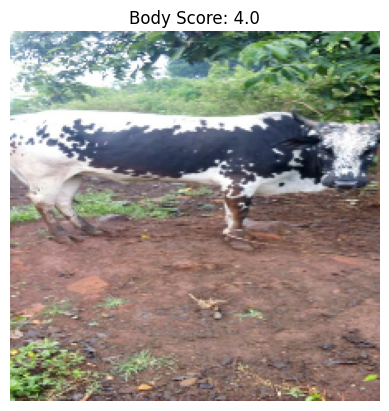

In [10]:
#view contents of dataset
for item in dataset.take(1):
    plt.title(f'Body Score: {item[1].numpy()}')
    plt.imshow(item[0].numpy())
    plt.axis('off')

In [11]:
#shuffle and batch data
dataset = dataset.shuffle(buffer_size=2000)
dataset = dataset.batch(batch_size=32)

In [12]:
#split data into train and val sets
dataset_length = 0
for _ in dataset:
    dataset_length+=1
print(dataset_length)
train_size = int(dataset_length*0.7)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

238


In [13]:
#create model
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    pooling='avg',
)

model = Sequential()
model.add(base_model)
# model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
# model.add(layers.MaxPool2D())
# model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
# model.add(layers.MaxPool2D())
model.add(layers.Flatten())
model.add(layers.Dense(units=1024, activation='relu'))
model.add(layers.Dense(units=1, activation='relu'))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
#compile model
model.compile(loss=losses.mae, optimizer=optimizers.Adam(learning_rate = 0.0001))

In [15]:
#compile model
#model.compile(loss=losses.mae, optimizer=optimizers.RMSprop(learning_rate = 0.001))

In [16]:
#train model
model.fit(train_dataset, validation_data=val_dataset, epochs=60, batch_size=32)

Epoch 1/60


I0000 00:00:1724651097.637838      97 service.cc:145] XLA service 0x7b4d441a36e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724651097.638387      97 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1724651097.638397      97 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1724651125.551499      97 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_34', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1724651125.598155      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


166/166 ━━━━━━━━━━━━━━━━━━━━ 126s 386ms/step - loss: 0.9746 - val_loss: 1.2400
Epoch 2/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 61s 354ms/step - loss: 0.5709 - val_loss: 1.8381
Epoch 3/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 61s 354ms/step - loss: 0.4708 - val_loss: 0.7622
Epoch 4/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 82s 356ms/step - loss: 0.4387 - val_loss: 0.7085
Epoch 5/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 61s 355ms/step - loss: 0.3964 - val_loss: 0.7190
Epoch 6/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 62s 358ms/step - loss: 0.3501 - val_loss: 0.5864
Epoch 7/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 61s 356ms/step - loss: 0.3467 - val_loss: 0.4143
Epoch 8/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 62s 358ms/step - loss: 0.3169 - val_loss: 0.4115
Epoch 9/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 61s 356ms/step - loss: 0.3083 - val_loss: 0.3694
Epoch 10/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 61s 357ms/step - loss: 0.2922 - val_loss: 0.3539
Epoch 11/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 61s 354ms/step - loss: 0.2754 - val_loss: 0.3452
Epoch 12/60
166/166 ━━━━━━━━━

In [20]:
#load submission file
df_submit = pd.read_csv('/kaggle/working/body_score_dataset/sample_submission.csv')
df_submit.head()

,filename,bodyScore
0,b909623b-39b0-47e7-ba71-356d74d3f2cb5779846075...,0
1,8dc92b10-e198-4bad-a413-2cea6ef30e8c3040278561...,0
2,605f77a6-58e2-4d53-9821-cc9f760617f89211689386...,0
3,716bdb88-5a6f-4a9f-89fa-6c51b3a4a2a62638764935...,0
4,e92d6398-ab98-44fd-869e-7a3fac84f2976528877008...,0


In [21]:
#prepare test dataset
df_submit['filepath'] = df_submit.apply(lambda row: glob(f'body_score_dataset/**/{row.filename}')[0], axis=1)
df_submit_file_paths = df_submit.filepath.values
test_dataset = tf.data.Dataset.from_tensor_slices((df_submit_file_paths))
test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [22]:
#make predictions
predictions = model.predict(test_dataset)
predictions_flattened = predictions.flatten()
df_submit['bodyScore'] = [5.0 if i>5 else i for i in predictions_flattened]
df_submit[['filename', 'bodyScore']].to_csv('submission54.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step
